**Task:** Interpolate data from regular to curvilinear grid

    

**Solution:** [pyresample](https://code.google.com/p/pyresample/)

[Notebook file](http://nbviewer.ipython.org/github/koldunovn/earthpy.org/blob/master/content/notebooks/interpolation_between_grids_with_pyresample.ipynb)

Following two excellent contributions on interpolation between grids by [Nikolay](http://earthpy.org/interpolation_between_grids_with_basemap.html) Koldunov and [Oleksandr](http://earthpy.org/interpolation_between_grids_with_ckdtree.html) Huziy I would like to introduce a solution using the [pyresample](https://code.google.com/p/pyresample) package. I feel it is timely since pyresample does encapsulate the strategy presented by Oleksandr (which I totally support) in fewer function calls. There might also be a speed-up factor to consider for big datasets, since pyresample comes with its own implementation of KD-Trees which was tested faster than the scipy.spatial.cKDTree.

The same data as in Nikolay's and Oleksandr's post will be used for easing comparison.

Some necessary imports:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#for netcdf
from netCDF4 import Dataset

#for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

#for array manipulation
import numpy as np

#for interpolation (you will have to install pyresample first)
import pyresample

#for downloading files
import urllib2

I repeat Oleksandr's routine for downloading data, and download of the NCEP dataset, as well as the target curvilinear grid:

In [4]:
def download_from_link(path):
    #download if it does not exist yet
    import os
    f_name = os.path.basename(path)
    if not os.path.isfile(f_name):
        remote_con = urllib2.urlopen(path)
        with open(f_name, "wb") as f:
            f.write(remote_con.read())

Load NCEP reanalysis data.

In [5]:
download_from_link("ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc")

We also need coordinates of the curvilinear grid: 

In [6]:
download_from_link("https://www.dropbox.com/s/9xzgyjs08zyuwzw/curv_grid.nc")

Now I'll skip exploring the data (take a look at Oleksandr's post) and concentrate on the reprojection of the NCEP values and the model's curvilinear grid.

In [7]:
# load lat-lon of the target grid
fc = Dataset('curv_grid.nc')
lon_curv = fc.variables['xc'][0,:,:]
lat_curv = fc.variables['yc'][0,:,:]
fc.close()

# load lat-lon-value of the origin data
fr = Dataset('air.mon.mean.nc')
air = fr.variables['air'][0,:,:]
lat = fr.variables['lat'][:]
lon = fr.variables['lon'][:]
fr.close()

# get 2D versions of the lat and lon variables (note the -180 here!)
lon2d, lat2d = np.meshgrid(lon - 180, lat)

When all the necessary inputs are read in memory, that's where we start using pyresample's magic.

Create a pyresample object holding the origin (NCEP) grid:

In [8]:
orig_def = pyresample.geometry.SwathDefinition(lons=lon2d, lats=lat2d)

Create another pyresample object for the target (curvilinear) grid:

In [9]:
targ_def = pyresample.geometry.SwathDefinition(lons=lon_curv, lats=lat_curv)

Resample (aka re-project, re-grid) the NCEP data to target grid. First with nearest neighbour resampling...

In [10]:
air_nearest = pyresample.kd_tree.resample_nearest(orig_def, air, \
        targ_def, radius_of_influence=500000, fill_value=None)

... then with the custom weight function as inverse of the distance (same as Oleksandr):

In [11]:
wf = lambda r: 1/r**2

In [13]:
air_idw = pyresample.kd_tree.resample_custom(orig_def, air, \
                           targ_def, radius_of_influence=500000, neighbours=10,\
                           weight_funcs=wf, fill_value=None)

(the warning indicates we might loose information by limiting to 10 neighbours...)

Pyresample also natively support gaussian-shaped weighting:

In [14]:
air_gauss = pyresample.kd_tree.resample_gauss(orig_def, air, \
                           targ_def, radius_of_influence=500000, neighbours=10,\
                           sigmas=250000, fill_value=None)

Now let us plot the results from these three approaches. We use imshow() that does not introduce additional interpolation.

In [17]:
fig = plt.figure(figsize=(5,15))

ax = fig.add_subplot(311)
ax.imshow(air_nearest,interpolation='nearest')
ax.set_title("Nearest neighbor")

ax = fig.add_subplot(312)
ax.imshow(air_idw,interpolation='nearest')
plt.title("IDW of square distance \n using 10 neighbors");

ax = fig.add_subplot(313)
ax.imshow(air_gauss,interpolation='nearest')
plt.title("Gauss-shape of distance (sigma=25km)\n using 10 neighbors");

Now let's say we do not want to resample to the curvilinear coordinates, but to a predefined Lambert Azimuthal Equal Area covering Southern Hemisphere (something based on NSIDC's [EASE](nsidc.org/data/ease) grids).

In [18]:
area_id = 'ease_nh'
name = 'Arctic EASE grid'
proj_id = 'ease_nh'
x_size = 425
y_size = 425
area_extent = (-5326849.0625,-5326849.0625,5326849.0625,5326849.0625)
proj_dict = {'a': '6371228.0', 'units': 'm', 'lon_0': '0','proj': 'laea', 'lat_0': '+90'}
targ_def = pyresample.geometry.AreaDefinition(area_id, name, proj_id, proj_dict, x_size, y_size, area_extent)
print targ_def

Area ID: ease_nh
Name: Arctic EASE grid
Projection ID: ease_nh
Projection: {'a': '6371228.0', 'lat_0': '+90', 'lon_0': '0', 'proj': 'laea', 'units': 'm'}
Number of columns: 425
Number of rows: 425
Area extent: (-5326849.0625, -5326849.0625, 5326849.0625, 5326849.0625)


Same function call as above:

In [19]:
air_gauss = pyresample.kd_tree.resample_gauss(orig_def, air, \
                           targ_def, radius_of_influence=500000, neighbours=10,\
                           sigmas=250000, fill_value=None)

And visualization:

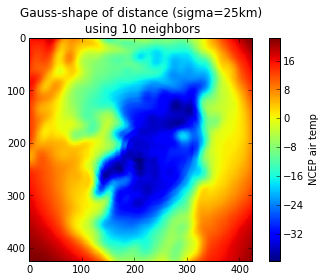

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(air_gauss.transpose(),interpolation='nearest')
fig.colorbar(im).set_label('NCEP air temp')
plt.title("Gauss-shape of distance (sigma=25km)\n using 10 neighbors");

Check the [pyressample](https://code.google.com/p/pyresample/) for more cool re-projection stuff, including resampling of satellite data!